In [1]:
import torch
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
filename = "dce_tensordata"
mri_tensor = torch.load(f"/home/suhkth/Desktop/DL-Breast-MRI-Tumor-Segmentation/convertData2PNG/{filename}.pth") # need to modified if necessary
print("MRI tensor shape:", mri_tensor.shape)

MRI tensor shape: torch.Size([1388, 6, 300, 300])


In [3]:
#  🔄 Convert to NumPy and normalize function

mri_numpy = mri_tensor.numpy()

# Normalization function for individual 2D slices
def normalize_slice(slice_2d):
    min_val = np.min(slice_2d)
    max_val = np.max(slice_2d)
    if max_val - min_val == 0:
        # Avoid divide by zero if slice is uniform
        return np.zeros_like(slice_2d, dtype=np.uint8)
    slice_2d_norm = (slice_2d - min_val) / (max_val - min_val)
    slice_2d_255 = (slice_2d_norm * 255).astype(np.uint8)
    return slice_2d_255

In [4]:
def apply_colormap(slice_2d_norm, cmap='plasma'):
    """
    Apply a matplotlib colormap to a 2D array that's already [0..1].
    Returns a (H, W, 3) RGB image in [0..255].
    """
    # Use matplotlib's get_cmap
    cm = plt.cm.get_cmap(cmap)
    # Apply colormap -> returns RGBA
    colored = cm(slice_2d_norm)
    # Convert RGBA -> RGB and scale to 0..255
    colored_rgb = (colored[..., :3] * 255).astype(np.uint8)
    return colored_rgb

In [5]:
# Create Output Folders
gray_dir = "mri_png_slices_gray"
plasma_dir = "mri_png_slices_plasma"
os.makedirs(gray_dir, exist_ok=True)
os.makedirs(plasma_dir, exist_ok=True)

In [6]:
# 💾  Save Slices in Both Grayscale & Plasma
num_slices, num_channels, height, width = mri_numpy.shape
print(f"Saving {num_slices} slices x {num_channels} channels => {num_slices*num_channels} images each in two folders...")

for slice_idx in range(num_slices):
    for ch_idx in range(num_channels):
        slice_2d = mri_numpy[slice_idx, ch_idx]

        # -------- GRAYSCALE --------
        gray_img = normalize_slice(slice_2d)
        Image.fromarray(gray_img).save(
            os.path.join(gray_dir, f"slice_{slice_idx:04d}_ch_{ch_idx}.png")
        )

        # -------- COLORMAP: PLASMA --------
        # First normalize to [0..1] for colormap
        slice_norm_01 = (slice_2d - slice_2d.min()) / (slice_2d.max() - slice_2d.min() + 1e-9)
        colored_rgb = apply_colormap(slice_norm_01, cmap='plasma')
        Image.fromarray(colored_rgb).save(
            os.path.join(plasma_dir, f"slice_{slice_idx:04d}_ch_{ch_idx}.png")
        )
        

print("✅ Done! Grayscale images in:", gray_dir)
print("✅ Done! Plasma-colored images in:", plasma_dir)


Saving 1388 slices x 6 channels => 8328 images each in two folders...


/tmp/ipykernel_23780/524263752.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap(cmap)


✅ Done! Grayscale images in: mri_png_slices_gray
✅ Done! Plasma-colored images in: mri_png_slices_plasma


In [7]:
# 👁️ Preview one sample image
sample_slice = 100
sample_channel = 0

# GRAYSCALE
gray_img = normalize_slice(mri_numpy[sample_slice, sample_channel])

# PLASMA
slice_2d = mri_numpy[sample_slice, sample_channel]
min_val, max_val = slice_2d.min(), slice_2d.max()
slice_norm_01 = (slice_2d - min_val) / (max_val - min_val + 1e-9)
colored_rgb = apply_colormap(slice_norm_01, cmap='plasma')

plt.figure(figsize=(15, 5))


/tmp/ipykernel_4279/524263752.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap(cmap)


<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

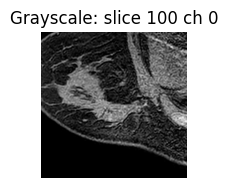

In [8]:
# Show Grey
plt.subplot(1, 3, 1)
plt.imshow(gray_img, cmap='gray')
plt.title(f"Grayscale: slice {sample_slice} ch {sample_channel}")
plt.axis('off')
plt.show()

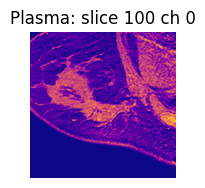

In [9]:
# Show plasma
plt.subplot(1, 3, 2)
plt.imshow(colored_rgb)
plt.title(f"Plasma: slice {sample_slice} ch {sample_channel}")
plt.axis('off')
plt.show()

In [ ]:
# Emphasize frames 2-4 in blending (post-contrast)
weights = torch.tensor([0.0, 0.1, 0.3, 0.4, 0.2, 0.1]).view(1, 6, 1, 1)

In [ ]:
blended_tensor = (mri_tensor * weights).sum(dim=1, keepdim=True)
print("Blended MRI tensor shape:", blended_tensor.shape)

In [ ]:
pre_contrast_tensor = mri_tensor[:, 0, :, :].unsqueeze(1)  # pre-contrast frame

In [ ]:
# Convert to numpy arrays
blended_numpy = blended_tensor.squeeze(1).numpy()  # [1388, 300, 300]
pre_contrast_numpy = pre_contrast_tensor.squeeze(1).numpy()  # [1388, 300, 300]

In [ ]:
# Create subtraction (enhancement) image
subtraction_numpy = blended_numpy - pre_contrast_numpy
subtraction_numpy[subtraction_numpy < 0] = 0  # remove negative values

In [ ]:
# Create Output Folders
gray_dir = "Blended_mri_gray"
os.makedirs(gray_dir, exist_ok=True)

In [ ]:
# Save pre, post, subtraction images sequentially
num_slices = blended_numpy.shape[0]

for idx in range(num_slices):
    # Pre-contrast image
    pre_slice = pre_contrast_numpy[idx]
    gray_pre = normalize_slice(pre_slice)

    Image.fromarray(gray_pre).save(f"{gray_dir}/slice_{idx:04d}_pre.png")
    Image.fromarray(plasma_pre).save(f"{plasma_dir}/slice_{idx:04d}_pre.png")

    # Blended post-contrast image
    post_slice = blended_numpy[idx]
    gray_post = normalize_slice(post_slice)

    Image.fromarray(gray_post).save(f"{gray_dir}/slice_{idx:04d}_post.png")
    Image.fromarray(plasma_post).save(f"{plasma_dir}/slice_{idx:04d}_post.png")

    # Subtraction image
    sub_slice = subtraction_numpy[idx]
    gray_sub = normalize_slice(sub_slice)

    Image.fromarray(gray_sub).save(f"{gray_dir}/slice_{idx:04d}_subtraction.png")

print("✅ Done! Images saved in grayscale with clear naming.")


In [ ]:
# Preview a sample combined image
sample_slice = 100

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Grayscale images
axs[0, 0].imshow(Image.open(f"{gray_dir}/slice_{sample_slice:04d}_pre.png"), cmap='gray')
axs[0, 0].set_title("Pre-Contrast (Gray)")
axs[0, 0].axis('off')

axs[0, 1].imshow(Image.open(f"{gray_dir}/slice_{sample_slice:04d}_post.png"), cmap='gray')
axs[0, 1].set_title("Post-Contrast Blended (Gray)")
axs[0, 1].axis('off')

axs[0, 2].imshow(Image.open(f"{gray_dir}/slice_{sample_slice:04d}_subtraction.png"), cmap='gray')
axs[0, 2].set_title("Subtraction (Gray)")
axs[0, 2].axis('off')


plt.tight_layout()
plt.show()